In [1]:
import sys
!{sys.executable} -m pip install kaggle_environments

In [16]:
from kaggle_environments import make,evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from math import inf, sqrt, log
from numpy import asarray
from random import choice
import pandas as pd
from multiprocessing import Pool

In [3]:
def connectx_agent(obs, config):

  import math
  import random
  import time
  import numpy as np

  def put_new_piece(grid, col, mark, config):
    next_state = grid.copy()
    for row in range(config.rows-1, -1, -1):
      if not next_state[row][col]:
        break
    next_state[row][col] = mark
    return next_state

  def check_result(grid, piece, config):

    def look_for_window(window):
      return (window.count(piece) == 4 and window.count(0) == config.inarow - 4)

    def calculate_windows():
      is_success = False
      sequences = ['horizontal', 'vertical', 'p_diagonal', 'n_diagonal']

      for sequence_type in sequences:

        if sequence_type == 'horizontal':
          for row in range(config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[row, col:col+config.inarow])
                if look_for_window(window):
                  return True

        elif sequence_type == 'vertical':
          for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns):
                window = list(grid[row:row+config.inarow, col])
                if look_for_window(window):
                  return True

        elif sequence_type == 'p_diagonal':
          for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                if look_for_window(window):
                  return True

        elif  sequence_type == 'n_diagonal':
          for row in range(config.inarow-1, config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                if look_for_window(window):
                  return True

      return is_success

    return calculate_windows()

  class MCTS():

    def __init__(self, obs, config):

      self.state = np.asarray(obs.board).reshape(config.rows, config.columns)
      self.config = config
      self.player = obs.mark
      self.final_action = None
      self.time_limit = self.config.timeout - 0.3
      self.root_node = (0,)
      self.tunable_constant = 1.0

      self.tree = {self.root_node:{'state':self.state, 'player':self.player,
                              'child':[], 'parent': None, 'total_node_visits':0,
                              'total_node_wins':0}}
      self.total_parent_node_visits = 0

    def get_ucb(self, node_no):
      if not self.total_parent_node_visits:
        return math.inf
      else:
        value_estimate = self.tree[node_no]['total_node_wins'] / (self.tree[node_no]['total_node_visits'] + 1)
        exploration = math.sqrt(2*math.log(self.total_parent_node_visits) / (self.tree[node_no]['total_node_visits'] + 1))
        ucb_score =  value_estimate + self.tunable_constant * exploration
        return ucb_score

    def selection(self):
      '''
      Aim - To select the leaf node with the maximum UCB
      '''
      is_terminal_state = False
      leaf_node_id = (0,)
      while not is_terminal_state:
        node_id = leaf_node_id
        number_of_child = len(self.tree[node_id]['child'])
        if not number_of_child:
          leaf_node_id = node_id
          is_terminal_state = True
        else:
          max_ucb_score = -math.inf
          best_action = leaf_node_id
          for i in range(number_of_child):
            action = self.tree[node_id]['child'][i]
            child_id = leaf_node_id + (action,)
            current_ucb = self.get_ucb(child_id)
            if current_ucb > max_ucb_score:
              max_ucb_score = current_ucb
              best_action = action
          leaf_node_id = leaf_node_id + (best_action,)
      return leaf_node_id

    def expansion(self, leaf_node_id):
      '''
      Aim - Add new nodes to the current leaf node by taking a random action
            and then take a random or follow any policy to take opponent's action.
      '''
      current_state = self.tree[leaf_node_id]['state']
      player_mark = self.tree[leaf_node_id]['player']
      current_board = np.asarray(current_state).reshape(config.rows*config.columns)
      self.actions_available = [c for c in range(self.config.columns) if not current_board[c]]
      done = check_result(current_state, player_mark, self.config)
      child_node_id = leaf_node_id
      is_availaible = False

      if len(self.actions_available) and not done:
        childs = []
        for action in self.actions_available:
          child_id = leaf_node_id + (action,)
          childs.append(action)
          new_board = put_new_piece(current_state, action, player_mark, self.config)
          self.tree[child_id] = {'state': new_board, 'player': player_mark,
                                 'child': [], 'parent': leaf_node_id,
                                 'total_node_visits':0, 'total_node_wins':0}

          if check_result(new_board, player_mark, self.config):
            best_action = action
            is_availaible = True

        self.tree[leaf_node_id]['child'] = childs
        
        if is_availaible:
          child_node_id = best_action
        else:
          child_node_id = random.choice(childs)

      return leaf_node_id + (child_node_id,)

    def simulation(self, child_node_id):
      '''
      Aim - Reach the final state of the game
      '''
      self.total_parent_node_visits += 1
      state = self.tree[child_node_id]['state']
      previous_player = self.tree[child_node_id]['player']

      is_terminal = check_result(state, previous_player, self.config)
      winning_player = previous_player
      count = 0

      while not is_terminal:

        current_board = np.asarray(state).reshape(config.rows*config.columns)
        self.actions_available = [c for c in range(self.config.columns) if not current_board[c]]

        if not len(self.actions_available) or count==3:
          winning_player = None
          is_terminal = True

        else:
          count+=1
          if previous_player == 1:
            current_player = 2
          else:
            current_player = 1

          for actions in self.actions_available:
            state = put_new_piece(state, actions, current_player, self.config)
            result = check_result(state, current_player, self.config)
            if result: # A player won the game
              is_terminal = True
              winning_player = current_player
              break


        previous_player = current_player

      return winning_player

    def backpropagation(self, child_node_id, winner):
      '''
      Aim - Update the traversed nodes
      '''
      player = self.tree[(0,)]['player']

      if winner == None:
        reward = 0
      elif winner == player:
        reward = 1
      else:
        reward = -10

      node_id = child_node_id
      self.tree[node_id]['total_node_visits'] += 1
      self.tree[node_id]['total_node_wins'] += reward

    def start_the_game(self):
      '''
      Aim - Complete MCTS iteration with all the process running for some fixed time
      '''
      self.initial_time = time.time()
      is_expanded = False

      while time.time() - self.initial_time < self.time_limit:
        node_id = self.selection()
        if not is_expanded:
          node_id = self.expansion(node_id)
          is_expanded = True
        winner = self.simulation(node_id)
        self.backpropagation(node_id, winner)
 
      current_state_node_id = (0,)
      action_candidates = self.tree[current_state_node_id]['child']
      total_visits = -math.inf
      for action in action_candidates:
        action = current_state_node_id + (action,)
        visit = self.tree[action]['total_node_visits']
        if visit > total_visits:
          total_visits = visit
          best_action = action
      
      return best_action

  my_agent = MCTS(obs, config)

  return my_agent.start_the_game()[1]


In [7]:
env = make('connectx',debug=True)
env.reset()
env.run([connectx_agent,connectx_agent])
x = env.render(mode='ipython',width=500,height=450)

In [13]:
env = make('connectx',debug=True)
env.reset()
env.run([connectx_agent,'negamax'])
x = env.render(mode='ipython',width=500,height=450)

In [14]:
env = make('connectx',debug=True)
env.reset()
env.run(['negamax',connectx_agent])
x = env.render(mode='ipython',width=500,height=450)

In [6]:
def ev(player1,player2):
    result = (evaluate('connectx',[player1,player2],num_episodes=100))
    return result

In [7]:
with Pool(processes=3) as pool:
    
    nm  = pool.apply_async(ev,args=('negamax',connectx_agent))
    mn = pool.apply_async(ev,args=(connectx_agent,'negamax'))
    mm = pool.apply_async(ev, args=(connectx_agent,connectx_agent))

    
    nega_mcts = nm.get()
    mcts_nega = mn.get()
    mcts_mcts = mm.get()
    pool.close()
    pool.join()


starting mn
starting mm


In [8]:
nega_mcts_df = pd.DataFrame(nega_mcts)
nega_mcts_df.value_counts()

0   1   
-1   1.0    66
 1  -1.0    31
Name: count, dtype: int64

In [9]:
mcts_nega_df = pd.DataFrame(mcts_nega)
mcts_nega_df.value_counts()

0   1 
 1  -1    77
-1   1    19
 0   0     4
Name: count, dtype: int64

In [10]:
mcts_mcts_df = pd.DataFrame(mcts_mcts)
mcts_mcts_df.value_counts()

0  1 
1  -1    100
Name: count, dtype: int64

In [35]:
mvm = mcts_mcts_df.replace([-1,0,1],['lose','tie','win']).rename(columns={0: 'player1',1: 'player2'})
mvn = mcts_nega_df.replace([-1,0,1],['lose','tie','win']).rename(columns={0: 'player1',1: 'player2'})
nvm = nega_mcts_df.replace([-1,0,1],['lose','tie','win']).rename(columns={0: 'player1',1: 'player2'})

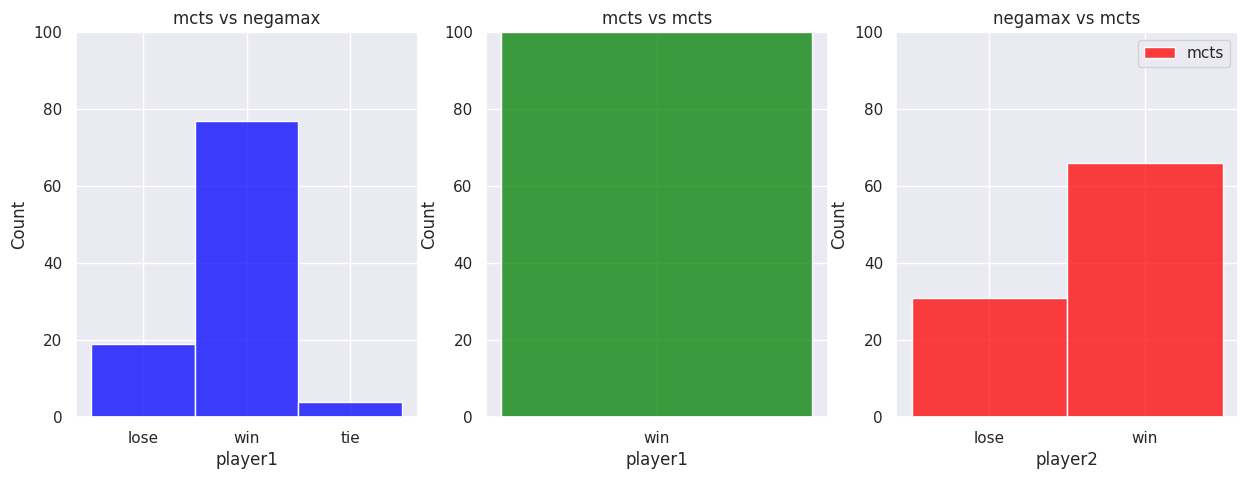

In [76]:
sns.set(style='darkgrid')
sns.set_palette('bright')
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=mvn, x= 'player1', label = 'mcts', ax=axs[0],color='blue')
axs[0].set_title('mcts vs negamax')
axs[0].set_ylim(0,100)
sns.histplot(data=mvm, x= 'player1', label = 'mcts', ax=axs[1],color='green')
axs[1].set_title('mcts vs mcts')
axs[1].set_ylim(0,100)
sns.histplot(data=nvm, x= 'player2', label = 'mcts', ax=axs[2],color='red')
axs[2].set_title('negamax vs mcts')
axs[2].set_ylim(0,100)
plt.legend()
plt.show()

In [17]:
env = make('connectx')
env.play([connectx_agent,None],width=500,height=500)